# Modeling Calcium Data
---

Exploring methods to generate synthetic signals that closely resemble real _C. elegans_ calcium imaging data. Since there are no governing or generating equations to describe neural activity as measured by calcium fluorescence, creating a known dataset that we can use to train our models allows us to test our hypotheses about the impact of data on our models' performance, as well as study scaling laws.

*Last update: 18 July, 2023*

In [1]:
%load_ext autoreload
%autorel

UsageError: Line magic function `%autorel` not found.


# Libraries and auxiliary functions
---

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as fft
import seaborn as sns
import torch

from omegaconf import OmegaConf
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from data._main import get_dataset
from utils import NEURONS_302
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import bootstrap
from scipy.stats import norm

In [3]:
def compute_R2(y_observed, y_predicted):
    # Calculate the mean of the observed data points
    mean_y = np.mean(y_observed)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_observed - mean_y) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_observed - y_predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared

In [4]:
def plot_spectrum(
    dataset,
    fft_freqs_np,
    magnitude_spectrum,
    phase_spectrum,
    fit_params,
    fit_quality,
    exponential_fits,
    idx=0,
):
    neuron_idx = np.where(dataset["worm0"]["named_neurons_mask"] == True)[0][idx]

    # Use whitegrid style from sns
    sns.set(style="whitegrid")
    # Use tab10 palette
    sns.set_palette("tab10")

    # Subplot the power spectrum and the phases
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].scatter(
        fft_freqs_np[:],
        magnitude_spectrum[:, idx],
        marker=".",
        label="Data points",
        alpha=0.5,
    )
    fit_label = "{} * exp(-{} * f) + {}".format(
        round(fit_params[idx, 0], 2),
        round(fit_params[idx, 1], 2),
        round(fit_params[idx, 2], 2),
    )
    axs[0].plot(
        fft_freqs_np[:], exponential_fits[:, idx], color="orange", label=fit_label
    )
    axs[0].set_title(
        "Magnitude spectrum (R²: {}) - {}".format(
            round(fit_quality[idx], 2),
            dataset["worm0"]["slot_to_named_neuron"][neuron_idx],
        )
    )
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Magnitude")
    axs[0].legend()

    axs[1].scatter(
        fft_freqs_np[:],
        phase_spectrum[:, idx],
        marker=".",
        label="Data points",
        alpha=0.5,
    )
    axs[1].set_title(
        "Phase spectrum - {}".format(
            dataset["worm0"]["slot_to_named_neuron"][neuron_idx]
        )
    )
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Phase")
    axs[1].legend()
    plt.tight_layout(pad=0.2)
    plt.show()

In [5]:
def plot_synthetic_data(dataset, synthetic_data, idx=0):
    scaler = StandardScaler()
    synthetic_data = scaler.fit_transform(synthetic_data)
    dataset["worm0"]["calcium_data"] = scaler.fit_transform(
        dataset["worm0"]["calcium_data"]
    )

    calcium_data = dataset["worm0"]["calcium_data"]
    mask = dataset["worm0"]["named_neurons_mask"]
    data = calcium_data[:, mask]

    time_steps = data.shape[0]
    time_vec = np.arange(time_steps) * 0.25

    # Use whitegrid style from sns
    sns.set(style="whitegrid")
    # Use tab10 palette
    sns.set_palette("tab10")

    # Plot the synthetic data and original data
    neuron_idx = np.where(dataset["worm0"]["named_neurons_mask"] == True)[0][idx]
    plt.figure(figsize=(10, 5))
    plt.plot(time_vec, data[:, idx], label="Original signal", alpha=0.5)
    plt.plot(time_vec, synthetic_data[:, idx], color="orange", label="Synthetic signal")
    plt.legend()
    plt.title(
        "Synthetic signal vs. Original signal ({})".format(
            dataset["worm0"]["slot_to_named_neuron"][neuron_idx]
        )
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Standardized calcium signal")
    plt.grid(True)

    plt.show()

In [6]:
def plot_synthetic_spectrum(
    synthetic_magnitude_spectrum, synthetic_phase_spectrum, frequencies, idx=0
):
    neuron_idx = 12

    # Use whitegrid style from sns
    sns.set(style="whitegrid")
    # Use tab10 palette
    sns.set_palette("tab10")

    # Subplot the power spectrum and the phases
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    axs[0].plot(
        frequencies,
        synthetic_magnitude_spectrum[:, neuron_idx],
        color="orange",
        label="Synthetic magnitude",
    )
    axs[0].set_title("Magnitude spectrum - {}".format(NEURONS_302[neuron_idx]))
    axs[0].set_xlabel("Frequency (Hz)")
    axs[0].set_ylabel("Magnitude")
    axs[0].legend()

    axs[1].scatter(
        frequencies,
        synthetic_phase_spectrum[:, neuron_idx],
        marker=".",
        label="Synthetic phases",
        alpha=0.5,
    )
    axs[1].set_title("Phase spectrum - {}".format(NEURONS_302[neuron_idx]))
    axs[1].set_xlabel("Frequency (Hz)")
    axs[1].set_ylabel("Phase")
    axs[1].legend()
    plt.tight_layout(pad=0.2)
    plt.show()

In [7]:
def bootstrap_mean(
    data_array,
    confidence_level=0.9,
    random_state=None,
    ax=None,
    title=None,
    xlabel=None,
):
    """Computes the bootstrap mean distribution of the given data.

    Parameters
    ----------
    data_array : array_like (1D)
        Input data. Samples must be in a sequence.
    confidence_level : float, optional
        Confidence level of the bootstrap distribution. Must be between 0 and 1.
    random_state : int, RandomState instance or None, optional
        Seed for the random number generator (if int), or numpy RandomState instance.

    Returns
    -------
    np.mean(res.bootstrap_distribution) : float
        Mean of the bootstrap distribution.
    res.standard_error : float
        Standard error of the bootstrap distribution.
    res.confidence_interval : tuple
        Confidence interval of the bootstrap distribution.
    """

    data = (data_array,)  # samples must be in a sequence
    rng = np.random.default_rng(random_state)
    res = bootstrap(data, np.mean, confidence_level=0.9, random_state=rng)

    if ax is not None:
        ax.hist(res.bootstrap_distribution, bins=25, density=True, alpha=0.75)
        ax.set_title("Bootstrap Mean Distribution (a coefficient)")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("PDF")

        # Draw vertical line on the mean
        ax.axvline(
            np.mean(res.bootstrap_distribution),
            color="black",
            linestyle="-.",
            alpha=0.5,
        )

        # Plot a gaussian with mean and std of the bootstrap distribution
        x = np.linspace(
            min(res.bootstrap_distribution),
            max(res.bootstrap_distribution),
            len(res.bootstrap_distribution),
        )
        y = norm.pdf(
            x, loc=np.mean(res.bootstrap_distribution), scale=res.standard_error
        )
        ax.plot(x, y, linestyle="-")

        # Shade inside the confidence intervals
        ax.fill_between(
            x,
            y,
            where=(x > res.confidence_interval[0]) & (x < res.confidence_interval[1]),
            alpha=0.5,
        )

        # Shade outside the confidence intervals
        ax.fill_between(
            x,
            y,
            where=(x < res.confidence_interval[0]) | (x > res.confidence_interval[1]),
            alpha=0.5,
        )

        if title is not None:
            ax.set_title(title)

        plt.tight_layout(pad=0.5)
        plt.grid(True)
        sns.set_style("whitegrid")

    return (
        np.mean(res.bootstrap_distribution),
        res.standard_error,
        res.confidence_interval,
    )

# Generating Synthetic data from the Fourier Spectrum
---

## Motivation

This method aims to extract a "signature" of the neurons by analyzing their Fourier spectrum (magnitude and phase). To start, we load the real data of a single neuron and take its Fourier transform, which leads to the frequency domain.

In [8]:
dataset_name = "Kato2015"
config = OmegaConf.load("/configs/submodule/dataset.yaml")
config.dataset.name = dataset_name

dataset = get_dataset(config)

Dataset loaded!
Chosen dataset(s): ['Kato2015']
Num. of worms: 12



We have observed that, for the majority of neurons, the magnitude spectrum can be approximated by a decaying exponential of the form:

$$ f(x) = Ae^{-Bx}+C $$

Therefore, we created a wrapping function that computes the Fourier transform of a single worm dataset. The function returns the magnitude and phase spectrum, as well as the corresponding $A$, $B$, and $C$ fitting coefficients.

In [9]:
def approximate_exponential_decay(single_worm_dataset):
    # Define the function to fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Define the function to fit
    def rational_func(x, a, b, c):
        return a * 1 / x**b + c

    calcium = single_worm_dataset["calcium_data"]
    mask = single_worm_dataset["named_neurons_mask"]
    dt = single_worm_dataset["resample_median_dt"]

    data = calcium[:, mask]

    fft_data = torch.fft.rfft(data, dim=0)  # only the real part
    fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)  # only the positive frequencies

    # Convert fft_data and fft_freqs to numpy for use with curve_fit
    fft_data_np = fft_data.detach().numpy()
    fft_freqs_np = fft_freqs.detach().numpy()

    # Magnitude spectrum
    magnitude_spectrum = np.abs(fft_data_np)

    # Phase spectrum
    phase_spectrum = np.angle(fft_data_np)

    # Fit function to each column of data in the power spectrum
    num_neurons = fft_data_np.shape[1]
    fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
    fit_quality = np.zeros(num_neurons)  # for storing the quality of fit

    for i in range(num_neurons):
        try:
            popt, pcov = curve_fit(func, fft_freqs_np, magnitude_spectrum[:, i])
        except RuntimeError:
            print("Error - curve_fit failed")
            continue
        fit_params[i, :] = popt  # each row is a, b, and c for a neuron
        # fit_quality[i] = np.sum((magnitude_spectrum[:, i] - func(fft_freqs_np, *popt)) ** 2) # calculate RSS
        # fit_quality[i] = np.sqrt(fit_quality[i]/len(magnitude_spectrum[:, i])-2) # calculate RSE
        fit_quality[i] = compute_R2(
            magnitude_spectrum[:, i], func(fft_freqs_np, *popt)
        )  # calculate R2

    # Generate x values
    f = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=fft_freqs_np.size)

    # Plot each fitted curve
    exponential_fits = np.zeros_like(fft_data_np)

    for i in range(num_neurons):
        # Generate y values for this curve
        exponential_fits[:, i] = func(f, *fit_params[i])

    return (
        fft_freqs_np,
        magnitude_spectrum,
        phase_spectrum,
        exponential_fits,
        fit_params,
        fit_quality,
    )

In [10]:
(
    fft_freqs_np,
    magnitude_spectrum,
    phase_spectrum,
    exponential_fits,
    fit_params,
    fit_quality,
) = approximate_exponential_decay(dataset["worm0"])

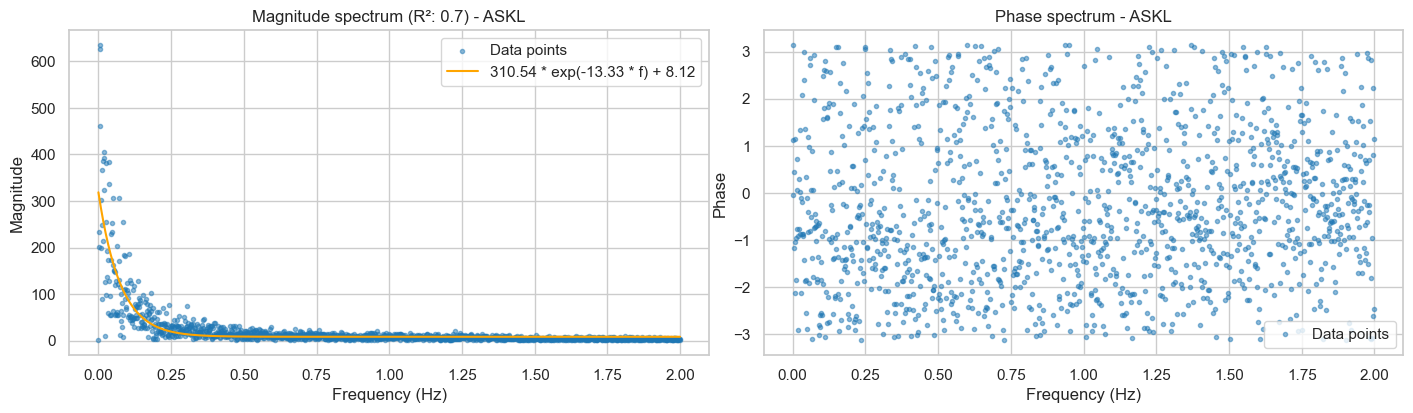

In [11]:
plot_spectrum(
    dataset,
    fft_freqs_np,
    magnitude_spectrum,
    phase_spectrum,
    fit_params,
    fit_quality,
    exponential_fits,
    idx=4,
)

The goal of mimicking the dynamics of neural data is to approximate the magnitude and phases of the Fourier transform of real signals. By knowing the governing equations of the Fourier spectrum, we can sample from the spectra and build a synthetic signal by inverting it to the time domain.

In this case, we will apply this process to the neuron shown above. We have created a function that synthesizes a time series from the exponential fit, which represents the neuron's "magnitude signature". At present, we are randomly sampling phases from a Gaussian distribution with a mean of zero and standard deviation of 1.8. However, in the next section, we will derive a method for extracting the neuron's phase distribution, which we will call the neuron's "phase signature".

In [12]:
def synthesize_time_series(exponential_fits, time_steps, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    num_freqs = exponential_fits.shape[0]
    synthetic_data = np.zeros((time_steps, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(
            0.0, 1.8, num_freqs
        )  # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return synthetic_data

In [13]:
synthetic_data = synthesize_time_series(
    exponential_fits, dataset["worm0"]["calcium_data"].shape[0], random_seed=42
)

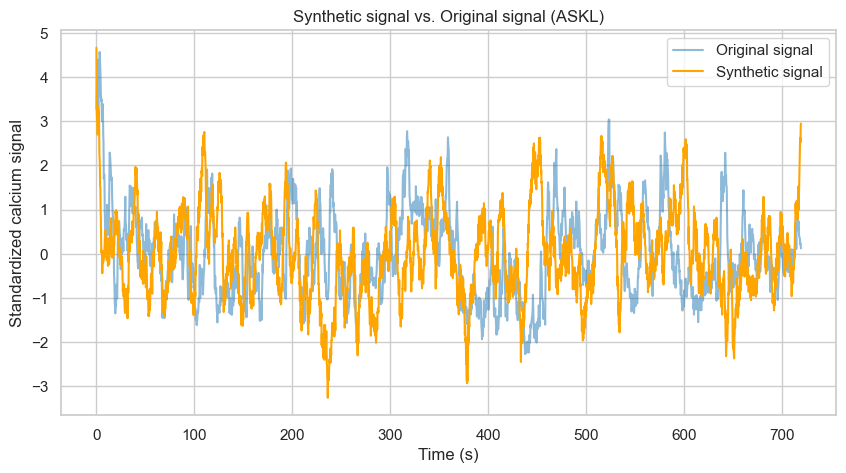

In [14]:
plot_synthetic_data(dataset, synthetic_data, idx=4)

As we can see, the synthetic signal follows the patterns of the real one with the same characteristics. The next step is to generalize how we generate these exponential curves and sample the phases.

## Pipeline

This pipeline loads all available datasets and extracts, for each neuron, its $A$, $B$, and $C$ coefficients, as well as the mean and standard deviation of the phases.

In [15]:
# Pipeline for phase distribution: compute the mean of the phases for each neuron of every individual


def distribution_params():
    dataset_names = [
        "Flavell2023",
        "Kato2015",
        "Nichols2017",
        "Skora2018",
        "Uzel2022",
        "Kaplan2020",
    ]  # Leifer2023 - 103 worms

    phases = np.zeros((143, 302, 2))  # (individual, neuron, (mu, std))
    exp_decay_params = np.zeros((143 + 103, 302, 3))  # (individual, neuron, (a, b, c))

    worm_count = 0

    for ds_name in dataset_names:
        # Load a single dataset
        config = OmegaConf.load("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml")
        config.dataset.name = ds_name

        dataset = get_dataset(config)

        # Iterate over worms in the dataset
        for wormid, data in dataset.items():
            (
                fft_freqs_np,
                magnitude_spectrum,
                phase_spectrum,
                exponential_fits,
                fit_params,
                fit_quality,
            ) = approximate_exponential_decay(data)

            if (not fit_params is None) and (not phase_spectrum is None):
                for i, named_neuron in enumerate(data["slot_to_named_neuron"]):
                    phases[worm_count, named_neuron, 0] = np.mean(
                        phase_spectrum[:, i]
                    )  # mu
                    phases[worm_count, named_neuron, 1] = np.std(
                        phase_spectrum[:, i]
                    )  # std

                    exp_decay_params[worm_count, named_neuron, 0] = fit_params[
                        i, 0
                    ]  # a
                    exp_decay_params[worm_count, named_neuron, 1] = fit_params[
                        i, 1
                    ]  # b
                    exp_decay_params[worm_count, named_neuron, 2] = fit_params[
                        i, 2
                    ]  # c

            worm_count += 1

    return phases, exp_decay_params

In [16]:
phases, exp_decay_params = distribution_params()

Dataset loaded!
Chosen dataset(s): ['Flavell2023']
Num. of worms: 50

Error - curve_fit failed
Dataset loaded!
Chosen dataset(s): ['Kato2015']
Num. of worms: 12

Dataset loaded!
Chosen dataset(s): ['Nichols2017']
Num. of worms: 44

Dataset loaded!
Chosen dataset(s): ['Skora2018']
Num. of worms: 12

Dataset loaded!
Chosen dataset(s): ['Uzel2022']
Num. of worms: 6

Dataset loaded!
Chosen dataset(s): ['Kaplan2020']
Num. of worms: 19



## Neuron phase signature

As shown in the motivation, there is no clear relation between the phases and the frequency.

To address this problem, we examine the statistics of the mean and standard deviation of the neuron phases. As some neurons have a small number of records, we estimate distribution of the the mean and standard deviation of the phases using a bootstrapping method.

In [17]:
log = open("log.txt", "w")

phase_signature = np.zeros((2, len(NEURONS_302)))  # (neuron, (mu, std))

count_neurons_with_no_values = 0

for i, neuron_name in enumerate(NEURONS_302):
    mask = np.where(phases[:, i, 0] != 0)[0]
    neuron_phases_mean = phases[:, i, 0][mask]  # mu
    neuron_phases_std = phases[:, i, 1][mask]  # std

    if np.sum(neuron_phases_mean) == 0:
        # Write in the log the neurons with no values
        log.write("Neuron {} has no values\n".format(neuron_name))
        count_neurons_with_no_values += 1

    else:
        if len(neuron_phases_mean) <= 1 or len(neuron_phases_std) <= 1:
            # Write in the log the neurons with only one value
            log.write("Neuron {} has only one value\n".format(neuron_name))
            continue
        phase_signature[0, i], _, _ = bootstrap_mean(neuron_phases_mean)  # mean, std
        phase_signature[1, i], _, _ = bootstrap_mean(neuron_phases_std)  # mean, std

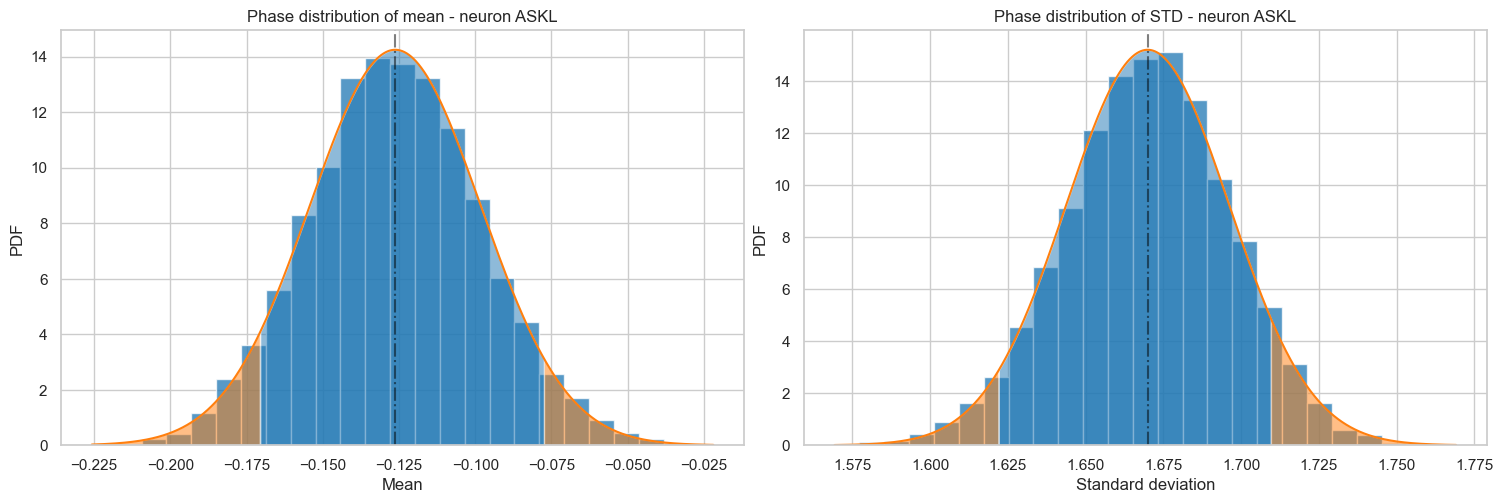

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

neuron_idx = 49

mask = np.where(phases[:, neuron_idx, 0] != 0)[0]  # neuron missing values mask

phase_mean = phases[:, neuron_idx, 0][mask]
phase_std = phases[:, neuron_idx, 1][mask]

_ = bootstrap_mean(
    phase_mean,
    ax=axs[0],
    title="Phase distribution of mean - neuron {}".format(NEURONS_302[neuron_idx]),
    xlabel="Mean",
)
_ = bootstrap_mean(
    phase_std,
    ax=axs[1],
    title="Phase distribution of STD - neuron {}".format(NEURONS_302[neuron_idx]),
    xlabel="Standard deviation",
)

In [19]:
# Save the phase signature
np.save("phase_signature.npy", phase_signature)  # mu and std for each neuron

Therefore, when we want to sample phases for a given neuron, we can use the mean of the mean distribution and the mean of the standard deviation distribution as inputs to a Gaussian distribution.

## Neuron magnitude signature

The same principle applied for the decaying exponential coefficients.

In [20]:
# Create a log to save the prints when the neuron has no values
log = open("log.txt", "w")

count_neurons_with_no_values = 0

a_coeffs = np.zeros((2, len(NEURONS_302)))
b_coeffs = np.zeros((2, len(NEURONS_302)))
c_coeffs = np.zeros((2, len(NEURONS_302)))

for i, neuron_name in enumerate(NEURONS_302):
    mask = np.where(exp_decay_params[:, i, 0] != 0)[0]  # neuron missing values mask
    a_coeff = exp_decay_params[:, i, 0][mask]
    b_coeff = exp_decay_params[:, i, 1][mask]
    c_coeff = exp_decay_params[:, i, 2][mask]

    if np.sum(exp_decay_params[:, i, 0][mask]) == 0:
        # Write in the log the neurons with no values
        log.write("Neuron {} has no values\n".format(neuron_name))
        count_neurons_with_no_values += 1
    else:
        if len(a_coeff) <= 1 or len(b_coeff) <= 1 or len(c_coeff) <= 1:
            # Write in the log the neurons with only one value
            log.write("Neuron {} has only one value\n".format(neuron_name))
            continue
        a_coeffs[0, i], a_coeffs[1, i], _ = bootstrap_mean(a_coeff)  # mean, std
        b_coeffs[0, i], b_coeffs[1, i], _ = bootstrap_mean(b_coeff)  # mean, std
        c_coeffs[0, i], c_coeffs[1, i], _ = bootstrap_mean(c_coeff)  # mean, std

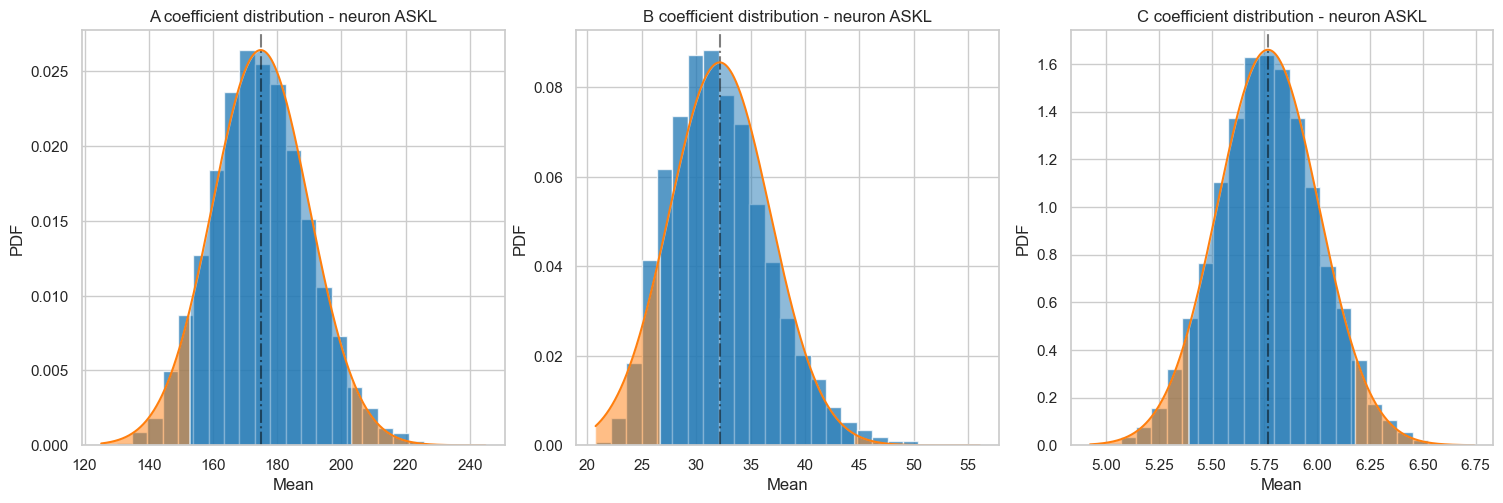

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

neuron_idx = 49
mask = np.where(exp_decay_params[:, neuron_idx, 0] != 0)[
    0
]  # neuron missing values mask
a_coeff = exp_decay_params[:, neuron_idx, 0][mask]
b_coeff = exp_decay_params[:, neuron_idx, 1][mask]
c_coeff = exp_decay_params[:, neuron_idx, 2][mask]

_ = bootstrap_mean(
    a_coeff,
    ax=axs[0],
    title="A coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
    xlabel="Mean",
)
_ = bootstrap_mean(
    b_coeff,
    ax=axs[1],
    title="B coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
    xlabel="Mean",
)
_ = bootstrap_mean(
    c_coeff,
    ax=axs[2],
    title="C coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
    xlabel="Mean",
)

In [22]:
# Save coefficients
np.save("a_coeffs.npy", a_coeffs)  # mu and std for each neuron
np.save("b_coeffs.npy", b_coeffs)  # mu and std for each neuron
np.save("c_coeffs.npy", c_coeffs)  # mu and std for each neuron

This time, we focus on the mean of the coefficients and use the bootstrapping method to generate a Gaussian distribution of the mean. We can then directly sample values from this distribution.

## Generating the synthetic signal

We can now (finally) generate a synthetic signal with all the pieces that we worked so far.

To accomplish this, we randomly sample from the magnitude and phase signature distributions in Fourier space. We use the sampled coefficients to generate an exponential curve for the magnitude spectrum. We then combine the magnitude and phase to create the signal in Fourier space:

$$signal = \alpha e^{i \theta}$$

Here, $\alpha$ represents the synthetic magnitude spectrum and $\theta$ represents the synthetic phase spectrum.

Finally, we invert the Fourier signal to retrieve it in the time domain.

In [104]:
def synthesize_neural_activity(time_steps, dt, random_seed=42):
    """Create a synthetic time series given a magnitude/phase neuron signature."""

    # Decaying exp func
    def decaying_exp(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    nyquist_freq = 1 / (2 * dt)
    freq_step = 1 / (time_steps * dt)
    frequencies = np.arange(0, nyquist_freq, freq_step)

    # Load magnitude spectrum parameters
    a_coeffs = np.load("synthetic/a_coeffs.npy")
    b_coeffs = np.load("synthetic/b_coeffs.npy")
    c_coeffs = np.load("synthetic/c_coeffs.npy")

    # Load phase spectrum parameters
    phases = np.load("synthetic/phase_signature.npy")

    # Store the synthetic data
    synthetic_data = np.zeros((time_steps, len(NEURONS_302)))

    # Store spectrums
    synthetic_magnitude_spectrum = np.zeros((len(frequencies), len(NEURONS_302)))
    synthetic_phase_spectrum = np.zeros((len(frequencies), len(NEURONS_302)))

    for i, neuron_name in enumerate(NEURONS_302):
        if a_coeffs[0, i] == 0.0:
            # We don't have the signature of this neuron
            continue

        else:
            # Sample a, b, c from a normal distribution
            a = np.random.normal(a_coeffs[0, i], a_coeffs[1, i], 1)
            b = np.random.normal(b_coeffs[0, i], b_coeffs[1, i], 1)
            c = np.random.normal(c_coeffs[0, i], c_coeffs[1, i], 1)

            # Generate the synthetic magnitude spectrum
            synthetic_magnitude_spectrum[:, i] = decaying_exp(frequencies, a, b, c)

            # Sample a phase from a normal distribution
            synthetic_phase_spectrum[:, i] = np.random.normal(
                phases[0, i], phases[1, i], len(frequencies)
            )

            # Clip the frequencies between -pi and pi
            synthetic_phase_spectrum[:, i] = np.clip(
                synthetic_phase_spectrum[:, i], -np.pi, np.pi
            )

            # Combine the power and phase spectra
            freq_domain_signal = synthetic_magnitude_spectrum[:, i] * np.exp(
                1j * synthetic_phase_spectrum[:, i]
            )

            # Perform the inverse Fourier transform to get the time series
            synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return (
        frequencies,
        synthetic_magnitude_spectrum,
        synthetic_phase_spectrum,
        synthetic_data,
    )

In [109]:
time_steps = 3000
dt = 0.25

(
    frequencies,
    synthetic_magnitude_spectrum,
    synthetic_phase_spectrum,
    synthetic_data,
) = synthesize_neural_activity(time_steps, dt, random_seed=42)

# Standard scale each column of the synthetic data
synthetic_data = StandardScaler().fit_transform(synthetic_data)

This is an example of generated signal:

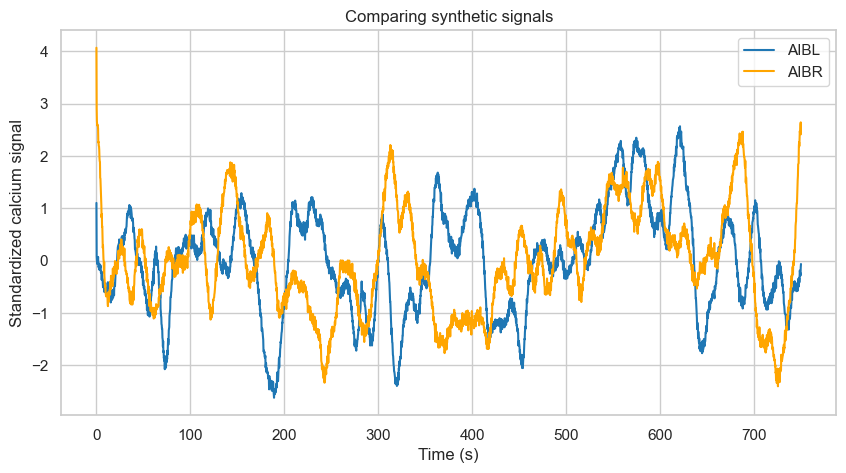

In [115]:
# Use whitegrid style from sns
sns.set(style="whitegrid")
# Use tab10 palette
sns.set_palette("tab10")

plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(time_steps) * dt,
    synthetic_data[:, 12],
    label=NEURONS_302[12],
)

plt.plot(
    np.arange(time_steps) * dt,
    synthetic_data[:, 13],
    color="orange",
    label=NEURONS_302[13],
)

plt.legend()
plt.title("Comparing synthetic signals")
plt.xlabel("Time (s)")
plt.ylabel("Standardized calcium signal")
plt.grid(True)

plt.show()

And the synthetic spectrum from which it comes:

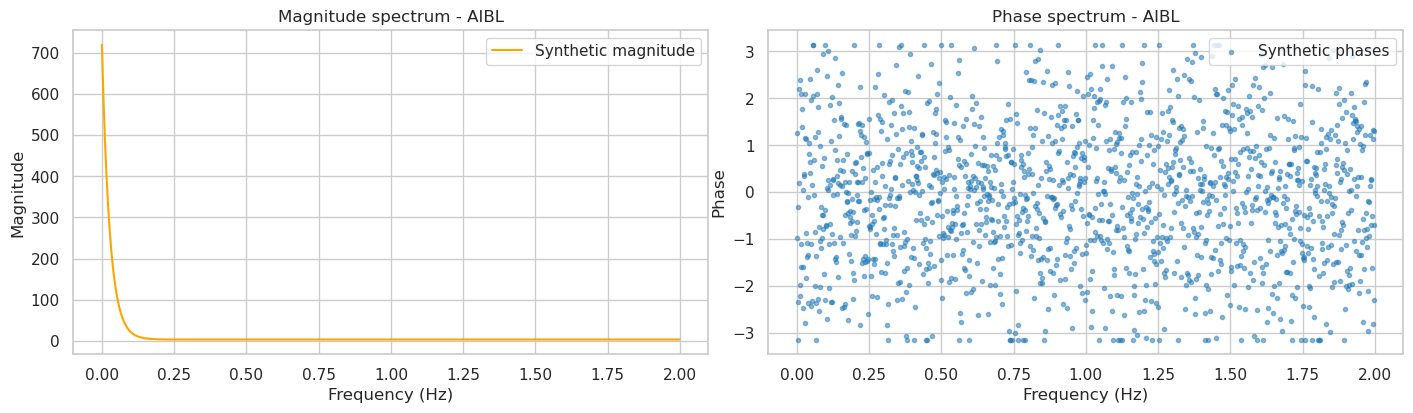

In [45]:
plot_synthetic_spectrum(
    synthetic_magnitude_spectrum, synthetic_phase_spectrum, frequencies, idx=12
)